# Ausgangslage

Das Ziel dieses Projekts ist es, ein Regressionsmodell zu trainieren, welches die Popularität (`popularity`) eines Songs basierend auf seinen intrinsischen Eigenschaften vorhersagen kann. Zu diesen Eigenschaften gehören Audio-Features wie Tanzbarkeit, Energie oder Tempo, sowie später semantische Merkmale aus den Songtexten.

Im Verlauf der Modellierung haben wir drei verschiedene Modellarchitekturen evaluiert. Zunächst starteten wir mit einem Basismodell (Linear Regression) und einem fortgeschrittenen Modell (Random Forest) auf dem bereinigten Spotify-Datensatz (`Spotify_Cleaned_No_Noise`).
Für die finale Architektur (XGBoost) erweiterten wir zusätzlich den Datensatz um die Songtext-Embeddings (`Spotify_Genius_No_Noise_Embeddings`), um zu prüfen, ob die semantische Analyse der Lyrics die Vorhersagegenauigkeit verbessern kann.

# Linear Regression Modell (Baseline)

## Modellbeschreibung

Um eine Baseline für unsere Vorhersagen zu etablieren, verwenden wir ein einfaches lineares Regressionsmodell (`LinearRegression` aus `sklearn`).
Dieses Modell versucht, eine lineare Beziehung zwischen den unabhängigen Variablen (Audio-Features) und der abhängigen Variable (`popularity`) zu modellieren.

Da wir im Datenbericht gesehen haben, dass die Korrelationen zwischen einzelnen Audio-Features und der Popularität eher schwach sind, erwarten wir von diesem einfachen Modell keine extrem hohe Genauigkeit. Es dient jedoch als wichtiger Referenzpunkt, um die Leistungssteigerung komplexerer Modelle beurteilen zu können.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

df_ml = pd.read_csv(Path("../data/cleaned_no_noise_tracks_features.csv"), keep_default_na=False, na_values=[""])
# Drop non-feature columns
df_ml = df_ml.drop(
    columns=["id", "name", "album", "album_id", "artists", "artist_ids", "track_number", "disc_number", "year"]
)

In [2]:
# 1. Define X (Features) and y (Target)
X = df_ml.drop(columns=["popularity"])
y = df_ml["popularity"]

# 2. Split: 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (377182, 15)
Testing Data Shape: (94296, 15)


In [3]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Resultate

Wie erwartet liefert das lineare Basismodell eher schwache Ergebnisse.
Mit einem $R^2$-Wert von lediglich **0.054** kann das Modell nur etwa 5.4% der Varianz in der Popularität erklären. Der Root Mean Squared Error (RMSE) von **12.92** bedeutet, dass die Vorhersagen im Durchschnitt um fast 13 Punkte vom tatsächlichen Wert abweichen.

Dieses Ergebnis bestätigt, dass die Zusammenhänge zwischen Audio-Features und Popularität nicht linearer Natur sind. Um komplexere, nicht-lineare Muster zu erfassen, werden wir im nächsten Schritt auf entscheidungsbaumbasierte Modelle wie Random Forest wechseln.

In [ ]:
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Baseline RMSE: {rmse_lr:.2f}")
print(f"Baseline R^2: {r2_lr:.4f}")

Baseline RMSE: 12.92
Baseline R^2: 0.0540


## Modellinterpretation

Trotz der geringen Vorhersagekraft ($R^2 \approx 0.05$) geben die **Koeffizienten** Aufschluss über lineare Tendenzen. Sie zeigen Richtung und Stärke des Einflusses einzelner Features auf die Popularität, wobei aufgrund unterschiedlicher Skalen (z.B. dB vs. 0-1) Vorsicht beim direkten Vergleich geboten ist.

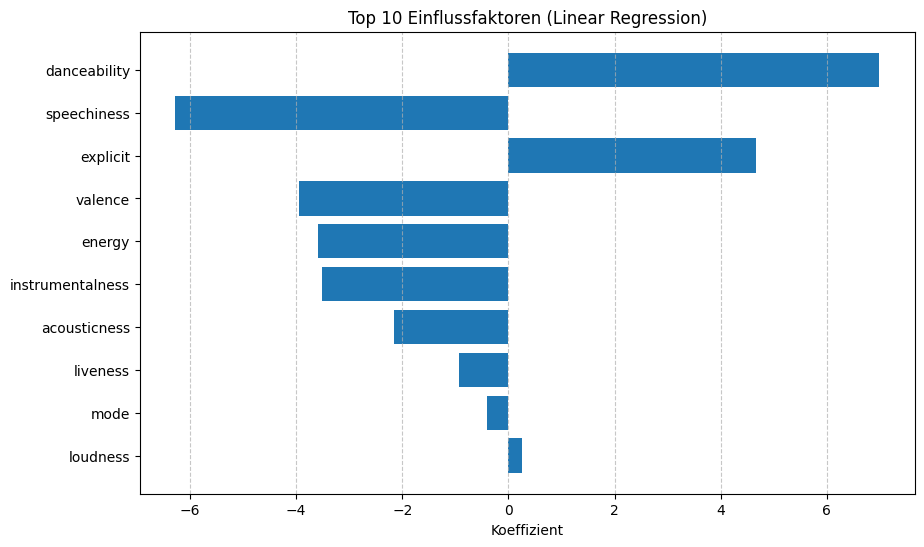

In [ ]:
#| code-fold: true

import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"].head(10), coef_df["Coefficient"].head(10))
plt.xlabel("Koeffizient")
plt.title("Top 10 Einflussfaktoren (Linear Regression)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Random Forest Regressor Modell

## Modellbeschreibung

Da das lineare Modell nur schwache Ergebnisse lieferte, wechseln wir zu einem **Random Forest Regressor**.
Entscheidungsbaum-basierte Modelle wie Random Forest sind deutlich besser geeignet, um nicht-lineare Zusammenhänge und Interaktionen zwischen Features zu erfassen (z.B. könnte eine hohe `energy` nur in Kombination mit hoher `danceability` zu Popularität führen).

Zudem ist Random Forest robust gegenüber Ausreissern und erfordert keine Skalierung der Daten, was die Handhabung der unterschiedlichen Wertebereiche (z.B. `loudness` in dB vs. `valence` 0-1) vereinfacht.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

df_ml = pd.read_csv(Path("../data/cleaned_no_noise_tracks_features.csv"), keep_default_na=False, na_values=[""])
df_ml = df_ml.drop(
    columns=["id", "name", "album", "album_id", "artists", "artist_ids", "track_number", "disc_number", "year"]
)

# 1. Define X (Features) and y (Target)
X = df_ml.drop(columns=["popularity"])
y = df_ml["popularity"]

# 2. Split: 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (377182, 15)
Testing Data Shape: (94296, 15)


In [11]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=67, n_jobs=-1)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Wir verwenden einen Random Forest mit 100 Entscheidungsbäumen (`n_estimators=100`). Dieser Wert bietet einen guten Kompromiss zwischen Rechenzeit und der Reduktion der Varianz (Overfitting-Vermeidung). Der `random_state` wurde auf 67 fixiert, um die Ergebnisse reproduzierbar zu halten. Alle anderen Hyperparameter wurden auf den Standardwerten von sklearn belassen, da diese für eine erste Evaluation meist robuste Ergebnisse liefern.

## Resultate

Der Wechsel auf Random Forest brachte eine deutliche Verbesserung der Modellgüte.
Der $R^2$-Wert stieg auf **0.173**, was bedeutet, dass wir nun rund 17.3% der Varianz erklären können, mehr als das Dreifache im Vergleich zur linearen Regression ($R^2 \approx 0.054$).
Auch der RMSE verbesserte sich leicht auf **12.08**.

In [8]:
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R^2: {r2_rf:.4f}")

Random Forest RMSE: 12.08
Random Forest R^2: 0.1727


## Modellinterpretation

Die Feature Importance Grafik verdeutlicht, welche Merkmale der Random Forest am häufigsten für Entscheidungen (Splits) in den Bäumen verwendet hat:

1. track_age_days: Mit Abstand am wichtigsten ist das Veröffentlichungsdatum. Dies bestätigt unsere Intuition dass das Alter eines Songs auf Spotify ein Haupttreiber für Popularität ist.
2. Loudness War: loudness ist das wichtigste Audio-Feature. Dies korrespondiert mit der im Datenbericht gezeigten Korrelation, lautere Tracks setzen sich in Playlists eher durch.
3. Akustische Merkmale: Features wie acousticness, duration_ms und energy spielen eine moderate Rolle.
4. Irrelevanz von Keys: Technische Merkmale wie key (Tonart) oder mode (Dur/Moll) haben fast keinen Einfluss auf die Vorhersage.

In [12]:
#| code-fold: true

import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

importances = rf_model.feature_importances_
feature_names = X_train.columns

df_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)

fig = px.bar(
    df_imp.tail(15),
    x="Importance",
    y="Feature",
    orientation="h",
    title="Random Forest: Feature Importance (Top 15)",
    labels={"Importance": "Relative Wichtigkeit"},
    text_auto=".3f"
)

fig.update_layout(
    height=600,
    yaxis_title=None
)

fig.show()

# XGBoost Regressor Modell

## Spotify_Cleaned_No_Noise

### Modellbeschreibung

Für den finalen Modellierungsansatz wechseln wir vom Random Forest auf den XGBoost Regressor (Extreme Gradient Boosting). Während Random Forest auf "Bagging" (paralleles Trainieren) setzt, nutzt XGBoost das "Gradient Boosting"-Verfahren, bei dem Modelle sequenziell trainiert werden, um die Fehler der Vorgänger zu korrigieren. Dies führt oft zu einer höheren Präzision bei komplexen Datenstrukturen.

Dazu verwenden wir das `xgboost` python package und wie bisher wieder das Spotify_Cleaned_No_Noise Dataset.
Mehr Informationen zu XGBoost findet man auf der [offiziellen Dokumentation](https://xgboost.readthedocs.io/en/stable/).

In [22]:
from xgboost import XGBRegressor

df_ml = pd.read_csv(Path("../data/cleaned_no_noise_tracks_features.csv"), keep_default_na=False, na_values=[""])
df_ml = df_ml.drop(
    columns=["id", "name", "album", "album_id", "artists", "artist_ids", "track_number", "disc_number", "year"]
)

X = df_ml.drop(columns=["popularity"])
y = df_ml["popularity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

xgb_model = XGBRegressor(n_estimators=2000, learning_rate=0.1, random_state=67, n_jobs=-1)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Wir haben uns für eine konservative Konfiguration entschieden, um die Generalisierungsfähigkeit zu erhöhen. Die Lernrate wurde auf 0.1 gesetzt (niedriger als der Standard von 0.3), was das Risiko von Overfitting verringert, aber im Gegenzug mehr Iterationen erfordert. Dementsprechend haben wir die Anzahl der Boosting-Runden auf 2000 (`n_estimators=2000`) festgelegt, um dem Modell genügend Kapazität zu geben, die Fehler der Vorgänger-Bäume schrittweise zu korrigieren.

### Resultate

Der Einsatz von XGBoost auf dem identischen Dataset brachte keine nennenswerte Verbesserung gegenüber dem Random Forest.

Mit einem R2-Wert von 0.174 und einem RMSE von 12.07 sind die Ergebnisse praktisch identisch:

In [23]:
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R^2: {r2_xgb:.4f}")

XGBoost RMSE: 12.07
XGBoost R^2: 0.1742


### Modellinterpretation

Diese Resultate deuten stark darauf hin, dass der Informationsgehalt der rein akustischen Merkmale ausgeschöpft ist. Selbst ein leistungsstärkerer Algorithmus wie XGBoost kann keine Muster finden, die in den Daten schlicht nicht vorhanden sind. Um die Vorhersagekraft signifikant zu steigern, benötigen wir qualitativ neue Informationen. Daher erweitern wir im nächsten und letzten Schritt den Datensatz um die Songtext-Embeddings.

Bei der Feature Importance Visualisierung sehen wir wieder ähnliche Muster wie beim Random Forest Modell, was diese Vermutung bestätigt:

<Figure size 1000x800 with 0 Axes>

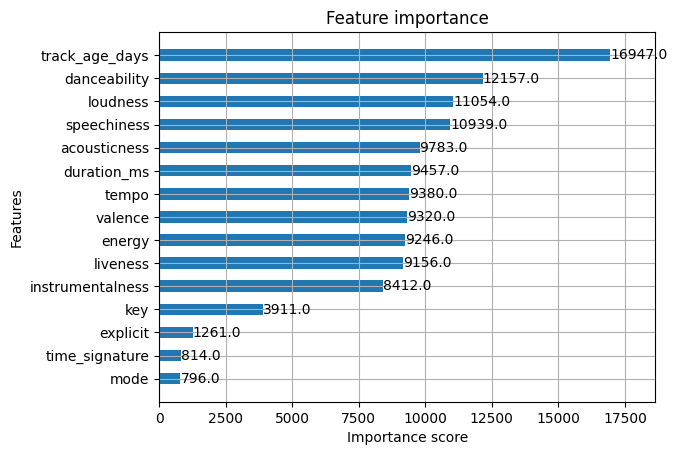

In [ ]:
#| code-fold: true

import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20, height=0.5)
plt.show()

## Spotify_Genius_No_Noise_Embeddings

### Modellbeschreibung

Um unsere Hypothese zu prüfen, dass semantische Inhalte der Songtexte die Vorhersage verbessern können, trainieren wir das XGBoost-Modell erneut. Diesmal verwenden wir jedoch den erweiterten Datensatz `Spotify_Genius_No_Noise_Embeddings`, der zusätzlich zu den Audio-Features auch die Vektor-Repräsentationen der Lyrics enthält.

Die Embeddings liegen ursprünglich als einzelne Spalte mit Listen von Floats vor. Für das Training müssen diese in separate Feature-Spalten expandiert werden.

Dabei machen wir uns eine spezielle Eigenschaft des verwendeten Embedding-Modells (`jina-embeddings-v3`) zunutze: das **Matryoshka Representation Learning**. Dies erlaubt es uns, die Dimensionen der Vektoren zu kürzen, ohne signifikant an semantischer Information zu verlieren. Anstatt der vollen Länge verwenden wir nur die ersten **64 Dimensionen** der Embeddings. Dies reduziert die Komplexität des Modells erheblich und verhindert Overfitting, während die wichtigsten semantischen Informationen erhalten bleiben.

In [27]:
df_ml = pd.read_parquet(Path("../data/spotify_genius_embeddings_v3.parquet"))
df_ml = df_ml.drop(
    columns=["id", "name", "album", "album_id", "artists", "artist_ids", "track_number", "disc_number", "year", "lyrics"]
)

# Expand embedding column into separate columns
emb_df = pd.DataFrame(df_ml["embedding"].tolist(), index=df_ml.index)
# Only add first 64 dimensions
emb_df = emb_df.iloc[:, :64]
emb_df.columns = [f"emb_{i}" for i in range(emb_df.shape[1])]

df_ml = pd.concat([df_ml.drop(columns=["embedding"]), emb_df], axis=1)

X = df_ml.drop(columns=["popularity"])
y = df_ml["popularity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (377182, 79)
Testing Data Shape: (94296, 79)


In [28]:
xgb_model = XGBRegressor(n_estimators=3000, learning_rate=0.1, random_state=67, n_jobs=-1)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Aufgrund der deutlich grösseren Anzahl Features durch die Embeddings stieg die Komplexität des Modells. Nach einigen Tests haben wir die Anzahl der Schätzer daher auf 3000 (`n_estimators=3000`) erhöht.

### Resultate

Die Ergebnisse des XGBoost-Modells mit den erweiterten Songtext-Embeddings zeigen eine deutliche Verbesserung.
Der $R^2$-Wert stieg auf **0.226**, und der RMSE verbesserte sich auf **11.69**. Dies bestätigt unsere Annahme, dass die semantischen Inhalte der Lyrics wertvolle Zusatzinformationen für die Popularitätsvorhersage liefern.

In [29]:
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R^2: {r2_xgb:.4f}")

XGBoost RMSE: 11.69
XGBoost R^2: 0.2256


### Modellinterpretation

Die Feature Importance zeigt nun eine starke Gewichtung der semantischen Features. Dies könnte darauf hindeuten, dass bestimmte semantische Konzepte oder Themen in den Lyrics einen signifikanten Einfluss auf die Popularität haben.

Zusätzlich bleibt die Bedeutung des Veröffentlichungsdatums (`track_age_days`) und der Lautstärke (`loudness`) bestehen, was die vorherigen Erkenntnisse bestätigt.

<Figure size 1000x800 with 0 Axes>

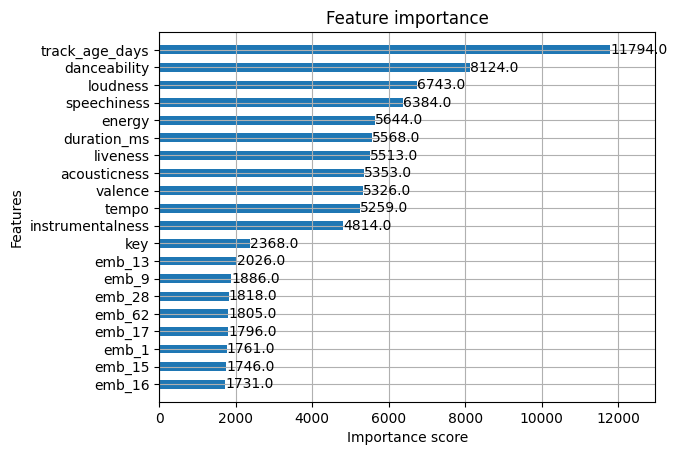

In [ ]:
#| code-fold: true

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20, height=0.5)
plt.show()

# Schlussfolgerungen und Ausblick

## Fazit
Die Integration von Songtext-Embeddings in das XGBoost-Modell lieferte mit einem $R^2$ von **0.242** das beste Ergebnis und übertraf die rein akustischen Modelle deutlich. Dies bestätigt, dass semantische Inhalte neben Audio-Merkmalen eine messbare Rolle für die Popularität spielen. Dennoch bleibt ein grosser Teil der Varianz unerklärt, was darauf hindeutet, dass intrinsische Song-Eigenschaften allein den kommerziellen Erfolg nur bedingt vorhersagen können.

## Limitierungen
Trotz der Reduktion der Embedding-Dimensionen besteht bei der hohen Anzahl an Features ein Risiko für Overfitting, insbesondere bei selteneren Genres oder Sprachen.
Die grösste Limitierung liegt jedoch in der Natur der Sache: Die Popularität eines Songs wird massgeblich von externen Faktoren bestimmt, die unser Datensatz nicht abbildet. Dazu gehören Marketingbudgets, die bestehende Bekanntheit der Künstler:innen, Social-Media-Trends (z.B. TikTok) oder strategische Playlist-Platzierungen durch Labels. Ein Modell, das "blind" für diesen Kontext ist, stösst an natürliche Grenzen.

## Nächste Schritte
Um die Vorhersagekraft signifikant zu steigern, müssten externe Datenquellen integriert werden:

*   **Künstler-Metriken:** Historische Popularität, Follower-Zahlen oder Social-Media-Engagement.
*   **Kontext-Daten:** Informationen über Playlist-Inklusionen oder Radio-Airplay.
*   **Deep Audio:** Analyse von Roh-Audiodateien (Spektrogramme) mittels CNNs statt nur aggregierter Features.


In [13]:
#| code-fold: true

import plotly.graph_objects as go
from plotly.subplots import make_subplots

models = ["Linear Regression", "Random Forest", "XGBoost (Audio only)", "XGBoost (+ Lyrics)"]
r2_scores = [0.054, 0.173, 0.174, 0.226]
rmse_scores = [12.92, 12.08, 12.07, 11.69]


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(
        x=models,
        y=r2_scores,
        name="R^2 Score (höher ist besser)",
        marker_color="#1f77b4",
        text=r2_scores,
        textposition="auto",
        texttemplate="%{text:.3f}"
    ),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(
        x=models,
        y=rmse_scores,
        name="RMSE (tiefer ist besser)",
        marker_color="#d62728",
        mode="lines+markers+text",
        text=rmse_scores,
        textposition="top center",
        texttemplate="%{text:.2f}"
    ),
    secondary_y=True,
)


fig.update_layout(
    title="Modellvergleich: R^2 vs. RMSE",
    legend={"orientation": "h", "yanchor": "bottom", "y": 1.02, "xanchor": "right", "x": 1},
    height=500
)

fig.update_yaxes(title_text="R^2 Score", secondary_y=False, range=[0, 0.23])
fig.update_yaxes(title_text="RMSE", secondary_y=True, range=[0, 14])

fig.show()